# MODEL COMPARISON

## Load libraries

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.7.1


In [2]:
az.style.use("arviz-darkgrid")

## Load data

In [3]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

## Pooled model

### Model specification

In [4]:
with pm.Model() as pooled:
    # Latent pooled effect size
    mu = pm.Normal('mu', 0, sigma = 1e6)
    
    # Likelihood
    obs = pm.Normal('obs', mu, sigma = sigma, observed = y)

### Run chains

In [5]:
with pooled:
    traceP = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 72 seconds.


### Check chains

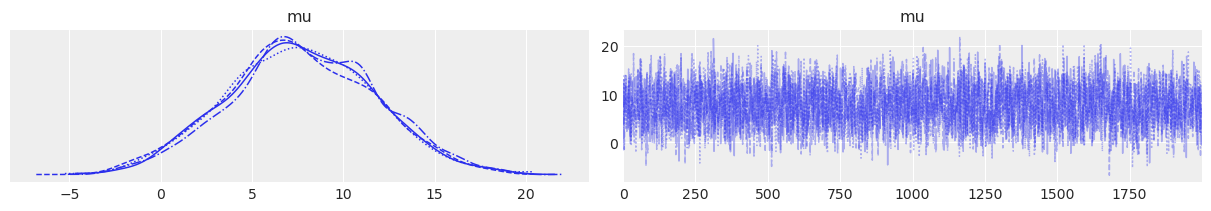

In [7]:
az.plot_trace(traceP);

## Hierarchical model

### Model specification

In [8]:
with pm.Model() as hierarchical:
    eta = pm.Normal('eta', 0, 1, shape = J)
    # Hierarchical mean and SD
    mu = pm.Normal('mu', 0, sigma = 10)
    tau = pm.HalfNormal('tau', 10)
    
    # Non-centered parametrization of random effect
    theta = pm.Deterministic('theta', mu + tau * eta)
    
    # Likelyhood
    
    obs = pm.Normal('obs', theta, sigma = sigma, observed = y)

### Run chains

In [9]:
with hierarchical:
    traceH = pm.sample(2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


### Check chains

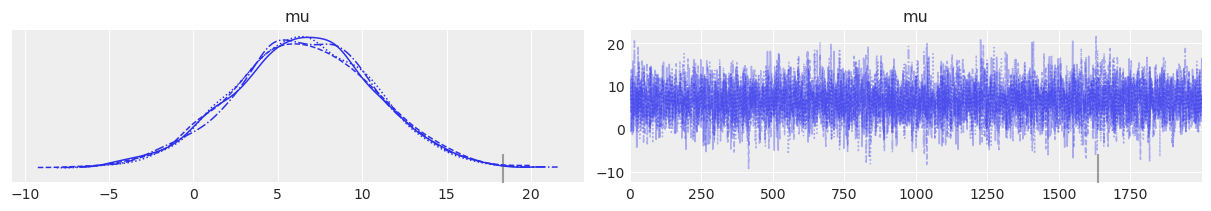

In [12]:
az.plot_trace(traceH, var_names = 'mu');

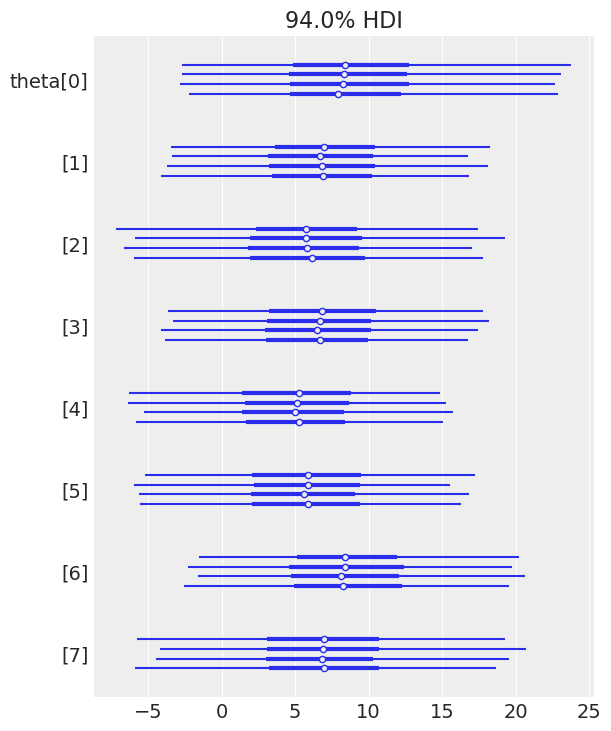

In [14]:
az.plot_forest(traceH, var_names = 'theta');

## Model log-likelihood

In [15]:
with pooled:
    pm.compute_log_likelihood(traceP)

In [16]:
pooled_loo = az.loo(traceP)

pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.56     1.11
p_loo        0.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
with hierarchical:
    pm.compute_log_likelihood(traceH)

In [19]:
hierarchical_loo = az.loo(traceH)

hierarchical_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.81     1.06
p_loo        1.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   62.5%
 (0.5, 0.7]   (ok)          3   37.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Compare models

In [20]:
dfCompLoo = az.compare({"hierarchical": traceH, "pooled": traceP})

dfCompLoo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.558217,0.671332,0.000000,1.000000e+00,1.105164,0.000000,False,log
hierarchical,1,-30.806661,1.158412,0.248444,6.661338e-16,1.063969,0.201557,False,log


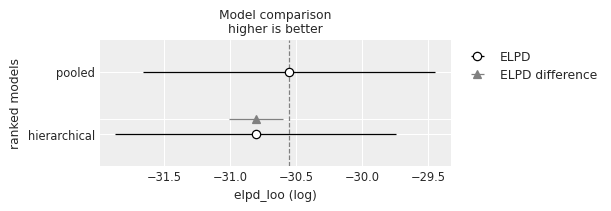

In [23]:
az.plot_compare(dfCompLoo, insample_dev = False);